# Train a JointVAE model

### Get MNIST data
Build a simple JointVAE model on MNIST

In [1]:
VAE_TRAIN = False
FIND_DIST = False
FOLDER = "dist7-svhn"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
from dataloaders import get_svhn_dataloader
# train_loader, test_loader = get_mnist_dataloaders_attack(2, 5, train_batch_size=64, test_batch_size=64, path_to_data='/home/data/bvaa')
train_loader, test_loader = get_svhn_dataloader(batch_size=32, path_to_data='/home/data/bvaa')

Using downloaded and verified file: /home/data/bvaa/train_32x32.mat
Using downloaded and verified file: /home/data/bvaa/test_32x32.mat


In [4]:
from torchvision import datasets, transforms
all_transforms = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])
train_data = datasets.SVHN('/home/data/bvaa/', split='train', download=True,
                                transform=all_transforms)

Using downloaded and verified file: /home/data/bvaa/train_32x32.mat


In [5]:
train_data[1][0].shape

torch.Size([3, 32, 32])

### Define latent distribution of the model

In [6]:
# Latent distribution will be joint distribution of 10 gaussian normal distributions
# and one 10 dimensional Gumbel Softmax distribution
latent_spec = {'cont': 32,
               'disc': [10]}
latent_dim = 42

### Build a model

### Train the model

In [7]:
## Classifiers

## Classifiers
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.float()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
#         print("x shape:", x.shape)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet152(num_classes, grayscale):
    """Constructs a ResNet-152 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[10, 9, 9, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=grayscale)
    return model




## Add here

In [8]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 10
BATCH_SIZE = 64
DEVICE = 'cuda:0' # default GPU device
GRAYSCALE = False

In [9]:
torch.manual_seed(RANDOM_SEED)

##########################
### COST AND OPTIMIZER
##########################

classifier = resnet152(NUM_CLASSES, GRAYSCALE)
classifier.to(DEVICE)

optimizer = torch.optim.Adam(classifier.parameters(), lr=LEARNING_RATE)

In [11]:
# import time

# from tqdm.notebook import tqdm

# def compute_accuracy(model, data_loader, device):
#     correct_pred, num_examples = 0, 0
#     for i, (features, targets) in enumerate(data_loader):
            
#         features = features.to(device)
#         targets = targets.to(device)

#         logits, probas = model(features)
#         _, predicted_labels = torch.max(probas, 1)
#         num_examples += targets.size(0)
#         correct_pred += (predicted_labels == targets).sum()
#     return correct_pred.float()/num_examples * 100
    

# start_time = time.time()
# for epoch in tqdm(range(100)):
    
#     classifier.train()
#     for batch_idx, (features, targets) in enumerate(train_loader):
        
#         features = features.to(DEVICE)
#         targets = targets.to(DEVICE)
            
#         ### FORWARD AND BACK PROP
#         logits, probas = classifier(features)
#         cost = F.cross_entropy(logits, targets)
#         optimizer.zero_grad()
        
#         cost.backward()
        
#         ### UPDATE MODEL PARAMETERS
#         optimizer.step()
        
#         ### LOGGING
#         if not batch_idx % 50:
#             print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
#                    %(epoch+1, NUM_EPOCHS, batch_idx, 
#                      len(train_loader), cost))

        

#     classifier.eval()
#     with torch.set_grad_enabled(False): # save memory during inference
#         print('Epoch: %03d/%03d | Train: %.3f%% | Valid: %.3f%%' % (
#               epoch+1, NUM_EPOCHS, 
#               compute_accuracy(classifier, train_loader, device=DEVICE),
#               compute_accuracy(classifier, test_loader, device=DEVICE)))
        
#     print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
# print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

In [13]:
# torch.save(classifier.state_dict(), './models/svhn/classifier.pt')

In [10]:
classifier = resnet152(NUM_CLASSES, GRAYSCALE)
classifier.to(DEVICE)

classifier.load_state_dict(torch.load('models/svhn/classifier.pt'))
classifier.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
from training import Trainer
from models import VAE
from torch import optim
model = VAE(latent_spec=latent_spec, img_size=(3, 32, 32), use_cuda=True).cuda()
# Define the capacities
# Continuous channels
cont_capacity =  [0.0, 50.0, 75000, 50.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 10.0, 75000, 50.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)    
    
# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity, use_cuda=True)

In [ ]:
# # Build a visualizer which will be passed to trainer to visualize progress during training
# from visualize import Visualizer

# viz = Visualizer(model)

In [12]:
# Train model for 10 epochs
# Note this should really be a 100 epochs and trained on a GPU, but this is just to demo

# trainer.train(train_loader, epochs=100, save_training_gif=('./training.gif', viz))
if VAE_TRAIN:
#     model.load_state_dict(torch.load('models/vae_svhn.pth'))
    trainer.train(train_loader, epochs=601)
#     torch.save(model.state_dict(), 'models/vae_svhn.pth')
else:
    model.load_state_dict(torch.load('models/vae_svhn.pth'))
    model.eval()

In [13]:
for param in model.parameters():
    param.requires_grad = False
    
for param in classifier.parameters():
    param.requires_grad = False

In [14]:
from madry_celeba import WideResNet
classifier2 = WideResNet(depth=28, num_classes=10, widen_factor=10, dropRate=0.0)
classifier2.load_state_dict(torch.load('models/svhn/model_9.pt'))

for param in classifier2.parameters():
    param.requires_grad = False

## Digits

In [15]:
list_index = {}
for i in range(len(train_data)):
    index = train_data[i][1]
    if index not in list_index.keys():
        list_index[index] = [i]
    else:
        list_index[index].append(i)

In [16]:
from tqdm.notebook import tqdm
l_sample_list = {}
def get_average_latent_space(list_index):
    for i in tqdm(list_index.keys()):
        for j in list_index[i]:
            output, l_dist = model(train_data[j][0].unsqueeze(0).cuda())
            l_sample_x = model.reparameterize(l_dist)
            if i not in l_sample_list.keys():
                l_sample_list[i] = [l_sample_x]
            else:
                l_sample_list[i].append(l_sample_x)
        l_sample_list[i] = {'mean':torch.mean(torch.stack(l_sample_list[i]), dim=0),
                           'std':torch.std(torch.stack(l_sample_list[i]), dim=0)}
        
get_average_latent_space(list_index)

In [17]:
# del train_data

In [18]:
import math
def check_distribution(digit, std=[-0.8, 0.8], plot=False):
    alpha = torch.clamp(torch.randn(l_sample_list[digit]['std'].shape).cuda(), min=std[0], max=std[1])
    test_sample = l_sample_list[digit]['mean'] + F.normalize(alpha)*l_sample_list[digit]['std']
    test = model.decode(test_sample)
#     preds = torch.argmax(classifier(F.upsample(test, (28,28), mode='bilinear', align_corners=True)))
#     print(preds.item())
    if plot:
        plt.imshow(test[0].permute(1, 2, 0).cpu().detach().numpy(), interpolation='none')
    return test_sample

tensor([[-6.1264e-03, -2.4839e-03, -9.5518e-02,  1.0699e-02, -2.6758e-02,
          7.5160e-03,  2.9028e-03, -1.0625e-03, -2.5612e-02,  2.3992e-02,
          1.6692e-02,  2.3557e-03, -7.4503e-03, -3.5428e-03,  3.1743e-03,
          7.7149e-03,  7.5046e-02,  1.5053e-03,  4.2091e-03, -1.3419e-02,
         -4.8085e-02,  2.2737e-03, -5.7337e-03, -3.3155e-03, -3.3956e-03,
         -4.1054e-04, -3.4614e-02,  8.6370e-04,  4.8837e-03,  1.0385e-01,
          1.0732e-03, -3.1260e-03,  1.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0')

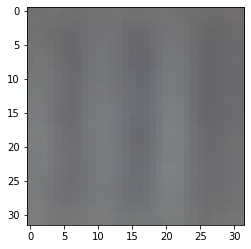

In [30]:
check_distribution(6, std=[-3,3], plot=True)

In [19]:
def digits_add(digit1, digit2, alpha=1, plot=False):
    l_1 = check_distribution(digit1)
    l_2 = check_distribution(digit2)
    if plot:
        test = model.decode(l_1+alpha*l_2)
        plt.imshow(test[0,0].cpu().detach().numpy(), cmap='gray', interpolation='none')
        preds = classifier(F.upsample(test, (28,28), mode='bilinear', align_corners=True))
        print(preds.dtype)
        print(torch.argmax(preds).item())
    return torch.norm(l_1-l_2), l_1, l_2

In [22]:
def get_avg_dist(digit1, digit2, exp=10000):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    distance = []
    similarity = []
    for i in range(exp):
        dist, l1, l2 = digits_add(digit1,digit2)
        similar = cos(l1,l2)
        distance.append(dist.item())
        similarity.append(similar.item())
    a = round(sum(distance)/len(distance),5)
    b = round(sum(similarity)/len(similarity),5)
    return a,b

In [23]:
def digit_to_study(digit):
    distance = {}
    similarity = {}
    for i in tqdm(range(10)):
        distance[i], similarity[i] = get_avg_dist(digit,i)
    return distance, similarity

In [ ]:
# get_avg_dist(1,3)

In [ ]:
# get_avg_dist(1,2)

In [ ]:
# get_avg_dist(2,3)

In [ ]:
digits_add(2,3,0.56,True)

In [ ]:
# digits_add(1,3,0.3,True)

In [ ]:
# digits_add(1,2,True)

In [ ]:
# digit_to_study(1)

In [ ]:
# digit_to_study(2)

In [ ]:
# check_distribution(2)

In [ ]:
# if FIND_DIST is True:
#     l_means = []
#     l_stds = []
#     for i in l_sample_list.keys():
#         l_means.append(l_sample_list[i]['mean'])
#         l_stds.append(l_sample_list[i]['std'])

#     l_mean_tensor = torch.stack(l_means).squeeze(1)
#     # print(l_mean_tensor.shape)

#     l_std_tensor = torch.stack(l_stds).squeeze(1)
#     # print(l_std_tensor.shape)

#     torch.save(l_mean_tensor, 'tensor/latent_mean.pt')
#     torch.save(l_std_tensor, 'tensor/latent_std.pt')

# else:
#     l_mean_tensor = torch.load('tensor/latent_mean.pt')
#     l_std_tensor = torch.load('tensor/latent_std.pt')

### Visualize

In [34]:
examples = enumerate(test_loader)
batch_idx, (example_data,target) = next(examples)

In [35]:
def check(i, digit1, digit2):
    
    alpha = torch.clamp(torch.randn(l_sample_list[digit1]['std'].shape).cuda(), min=-1, max=1)
    test_sample = l_sample_list[digit1]['mean'] + F.normalize(alpha)*l_sample_list[digit1]['std']
    
    alpha = torch.clamp(torch.randn(l_sample_list[digit2]['std'].shape).cuda(), min=-1, max=1)
    test_sample += l_sample_list[digit2]['mean'] + F.normalize(alpha)*l_sample_list[digit2]['std']
    
    example_img = example_data[i,:,:,:].unsqueeze(0).cuda()
    output, l_dist = model(example_img)
    l_sample = model.reparameterize(l_dist)
    test_sample = l_sample + 0.4*test_sample
    test = model.decode(test_sample)
#     preds = torch.argmax(classifier(F.upsample(test, (28,28), mode='bilinear', align_corners=True)))
#     print(preds)
    plt.imshow(model.decode(test_sample)[0,0].cpu().detach().numpy(), cmap='gray', interpolation='none')

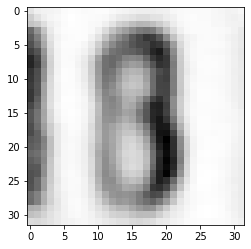

In [41]:
check(2,3,1)

In [42]:
def plot_mnist(list_to_process):
    new_l_sample = None
    count = len(list_to_process)
    for i in list_to_process:
        example_img = example_data[i,:,:,:].unsqueeze(0).cuda()
        output, l_dist = model(example_img)
        l_sample = model.reparameterize(l_dist)
        if new_l_sample is None:
            new_l_sample = l_sample
        else:
            new_l_sample += l_sample
    new_l_sample = new_l_sample / count
    new_output = model.decode(new_l_sample)
    plt.imshow(new_output[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')

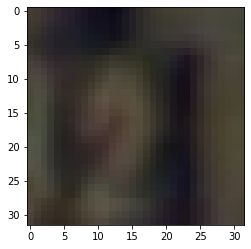

In [45]:
plt.imshow(example_data[17].permute(1,2,0).numpy())

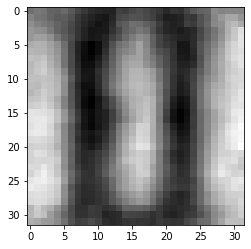

In [47]:
plot_mnist([17])

In [23]:
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.Tensor(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

ssim_loss = SSIM(window_size = 5)

In [21]:
use_cuda = True
device = torch.device('cuda' if use_cuda else 'cpu')

# Constrained Translator
class Noise(nn.Module):
    def __init__(self, hidden_layers=[50, 100, latent_dim], latent_dim=latent_dim):
        super(Noise, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_layers = hidden_layers
        self.hidden_layers.insert(0, latent_dim)
        self.layers = []
        
        for i in range(len(self.hidden_layers)-1):
            self.layers.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
        
        self.layers = nn.ModuleList(self.layers)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [22]:
# Constrained Cofficients
class Cofficients(nn.Module):
    def __init__(self, hidden_layers=[40, 20, 10, 1], latent_dim=latent_dim):
        super(Cofficients, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_layers = hidden_layers
        self.hidden_layers.insert(0, latent_dim)
        self.layers = []
        
        for i in range(len(self.hidden_layers)-1):
            self.layers.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
        
        self.layers = nn.ModuleList(self.layers)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [24]:
# from skimage.metrics import structural_similarity as ssim

use_cuda = True
device = torch.device('cuda' if use_cuda else 'cpu')


def create_logits(preds, device=device):
#     print(preds)
    preds = preds.cpu()
    logits = preds
    
    sorted_ = torch.argsort(preds, dim=1, descending=True)
    first = sorted_[:,0]
    second = sorted_[:,1]
    
    p_first = preds.gather(1, first.view(-1,1))
    p_second = preds.gather(1, second.view(-1,1))
#     print(p_first.shape)
    
    means = torch.mean(torch.stack([p_first, p_second]), dim=0).squeeze(1)
#     print(means.shape)
    diff = 0.5*(p_first - p_second).squeeze(1)
#     print(diff.shape)
    j = torch.arange(logits.size(0)).long()
    
    logits[j, first] = torch.FloatTensor(means - diff)
    logits[j, second] = torch.FloatTensor(means + diff)
    
    return logits.to(device), first, second

def structural(org_image, noised_image):
    batch_size, channels, width, height = org_image.shape
    loss1 = 0
    for b_ in range(batch_size):
        ch_loss = 0
        for ch_ in range(channels):
            ch_loss += 1-ssim(org_image[b_][ch_].detach().cpu().numpy(), noised_image[b_][ch_].detach().cpu().numpy())
        loss1 += ch_loss/channels
    return loss1
            
class T_Loss(nn.Module):
    def __init__(self, classifier=classifier, classifier2=classifier2, decoder=model.decode,
                 latent_dim=latent_dim, l_samples=l_sample_list,
                 classes=10):
        super(T_Loss, self).__init__()
        self.decoder = decoder
        self.classifier = classifier
#         self.means = means
#         self.stds = stds
        self.l_samples = l_samples
        self.classes = classes
        self.latent_dim = latent_dim
        self.classifier2 = classifier2
        
        
    def forward(self, coffs, noises, org_x, targets, alpha=0.6, beta=1, train=True):
        
        org_image = self.decoder(org_x)
        _,preds = self.classifier(F.upsample(org_image, (32,32), mode='bilinear', align_corners=True))
        
        alt_target, first, second = create_logits(preds)
        
        means = []
        stds = []
        
        for key in second:
            means.append(self.l_samples[key.item()]['mean'])
            stds.append(self.l_samples[key.item()]['std'])
        
        means = torch.stack(means)
        stds = torch.stack(stds)
        noised_latent = means.squeeze(1) + torch.clamp(noises, min=-5, max=5) * stds.squeeze(1)
        
        noised_latent = torch.clamp(coffs, min=-3, max=3) * noised_latent
#         noise_latent = F.normalize(coffs) * noise_latent
        
        noised_sample = beta * org_x + alpha * noised_latent
        
        noised_image = self.decoder(noised_sample)
        if train:
            _,preds = self.classifier(F.upsample(noised_image, (32,32), mode='bilinear', align_corners=True))
#         loss = 0.8*loss2 + 20*loss3
#         loss = loss2 + 20*loss3
            loss1 = ssim_loss(org_image, noised_image)
#             print(preds.shape)
#             print(alt_target.shape)
            alt_target.requires_grad = True
            loss2 = nn.BCELoss(reduction='sum')(preds, alt_target.float().detach())

            loss3 = torch.norm(org_image-noised_image, p=2)  

            loss = 500*(1-loss1) + loss2 + 30*loss3  
        else:
            preds = self.classifier2(F.upsample(noised_image, (32,32), mode='bilinear', align_corners=True))
            loss = 0

  
        
        out_labels = preds.argmax(dim=1, keepdim=True)

        correct = (out_labels.squeeze(1)==targets.cuda()).sum()

        return loss, correct.item()

In [25]:
# alt_target = 5
noise = Noise().to(device)
cofficient = Cofficients().to(device)

for param in noise.parameters():
    param.requires_grad=True
    
for param in cofficient.parameters():
    param.requires_grad=True

tloss = T_Loss().to(device)
tloss.eval()

T_Loss(
  (classifier): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [ ]:
# count_digit = 0
# for i in range(len(train_data)):
#     if train_data[i][1]==5:
#         count_digit += 1
# print(count_digit)

In [ ]:
from tqdm.notebook import tqdm
attack_log_interval = 1

noise.train()
cofficient.train()

optimizer1 = optim.Adam(noise.parameters(), lr=1e-4)
# optimizer1 = torch.optim.SGD(noise.parameters(), lr=1e-4, momentum=0.9)

# optimizer2 = torch.optim.SGD(cofficient.parameters(), lr=1e-4, momentum=0.9)
optimizer2 = optim.Adam(cofficient.parameters(), lr=1e-4)


# scheduler1 = torch.optim.lr_scheduler.CyclicLR(optimizer1, base_lr=1e-7, max_lr=0.1)
# scheduler2 = torch.optim.lr_scheduler.CyclicLR(optimizer2, base_lr=1e-7, max_lr=0.1)

for epoch in tqdm(range(150)):
    epoch_loss = 0
    epoch_correct = 0
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
#         print(target)
        data = torch.FloatTensor(data).to(device)
        _, l_dist = model(data)
        l_sample = model.reparameterize(l_dist)
        
        n = noise(l_sample)
        c = cofficient(l_sample)

        optimizer1.zero_grad()
        optimizer2.zero_grad()
        
        loss, correct = tloss(c, n, l_sample, target, alpha=0.5, beta=0.5)

        loss.backward()
        
        optimizer1.step()
        optimizer2.step()

#         scheduler1.step()
#         scheduler2.step()

        epoch_loss += loss.item()
    
        epoch_correct += correct
        
    if (epoch+1) % attack_log_interval == 0:
        print('Train Epoch: {}\tLoss: {:.6f}\tCorrect: {}'.format(
            epoch+1, epoch_loss/batch_idx, epoch_correct))

/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")



Train Epoch: 1	Loss: 1203.603041	Correct: 11270



Train Epoch: 2	Loss: 1230.460633	Correct: 10654



Train Epoch: 3	Loss: 1197.679811	Correct: 10424



Train Epoch: 4	Loss: 1134.602199	Correct: 10348



Train Epoch: 5	Loss: 1072.204436	Correct: 9979



Train Epoch: 6	Loss: 1012.164455	Correct: 9982



Train Epoch: 7	Loss: 987.547414	Correct: 10064



Train Epoch: 8	Loss: 980.511844	Correct: 10049



Train Epoch: 9	Loss: 942.620551	Correct: 10392



Train Epoch: 10	Loss: 969.182072	Correct: 10236



Train Epoch: 11	Loss: 966.512130	Correct: 10157



Train Epoch: 12	Loss: 932.625441	Correct: 10345



Train Epoch: 13	Loss: 957.296061	Correct: 10697



Train Epoch: 14	Loss: 973.352086	Correct: 10044



Train Epoch: 15	Loss: 936.999518	Correct: 10591



Train Epoch: 16	Loss: 919.663089	Correct: 10569



Train Epoch: 17	Loss: 919.196197	Correct: 10694



Train Epoch: 18	Loss: 912.623150	Correct: 10793



Train Epoch: 19	Loss: 903.468574	Correct: 11010



Train Epoch: 20	Loss: 886.914013	Correct: 11019



Train Epoch: 21	Loss: 900.457704	Correct: 11142



Train Epoch: 22	Loss: 899.812470	Correct: 11182



Train Epoch: 23	Loss: 884.030709	Correct: 11194



Train Epoch: 24	Loss: 899.451912	Correct: 11094



Train Epoch: 25	Loss: 894.284391	Correct: 11030



Train Epoch: 26	Loss: 896.480973	Correct: 10852



Train Epoch: 27	Loss: 891.380153	Correct: 10998



Train Epoch: 28	Loss: 903.527307	Correct: 11201



Train Epoch: 29	Loss: 896.031789	Correct: 11305



Train Epoch: 30	Loss: 919.206911	Correct: 11366



Train Epoch: 31	Loss: 916.912814	Correct: 11186



Train Epoch: 32	Loss: 941.857764	Correct: 11317



Train Epoch: 33	Loss: 958.770523	Correct: 11369



Train Epoch: 34	Loss: 949.121425	Correct: 11069



Train Epoch: 35	Loss: 921.489848	Correct: 11287



Train Epoch: 36	Loss: 933.867701	Correct: 11010



Train Epoch: 37	Loss: 913.507098	Correct: 11099



Train Epoch: 38	Loss: 912.557546	Correct: 11387



Train Epoch: 39	Loss: 883.102216	Correct: 11670



Train Epoch: 40	Loss: 864.112733	Correct: 11867



Train Epoch: 41	Loss: 875.628401	Correct: 11792



Train Epoch: 42	Loss: 893.856666	Correct: 11411



Train Epoch: 43	Loss: 915.779998	Correct: 10875



Train Epoch: 44	Loss: 895.985532	Correct: 11150



Train Epoch: 45	Loss: 903.596600	Correct: 11213



Train Epoch: 46	Loss: 909.602306	Correct: 11213



Train Epoch: 47	Loss: 905.090296	Correct: 11220



Train Epoch: 48	Loss: 901.478028	Correct: 11220



Train Epoch: 49	Loss: 896.399876	Correct: 11357



Train Epoch: 50	Loss: 906.262741	Correct: 10928



Train Epoch: 51	Loss: 882.285046	Correct: 11104



Train Epoch: 52	Loss: 905.232187	Correct: 10845



Train Epoch: 53	Loss: 889.204039	Correct: 11240



Train Epoch: 54	Loss: 905.704328	Correct: 11198



Train Epoch: 55	Loss: 890.851033	Correct: 11250



Train Epoch: 56	Loss: 876.430447	Correct: 11653



Train Epoch: 57	Loss: 872.025793	Correct: 11911



Train Epoch: 58	Loss: 875.921173	Correct: 11835



Train Epoch: 59	Loss: 855.937411	Correct: 12010



Train Epoch: 60	Loss: 843.456402	Correct: 12111



Train Epoch: 61	Loss: 858.433604	Correct: 12179



Train Epoch: 62	Loss: 854.093651	Correct: 12089



Train Epoch: 63	Loss: 861.577130	Correct: 11910



Train Epoch: 64	Loss: 875.857566	Correct: 11550



Train Epoch: 65	Loss: 879.975732	Correct: 11432



Train Epoch: 66	Loss: 863.903937	Correct: 11721


In [54]:
torch.save(noise.state_dict(), 'models/{}/noise.pt'.format(FOLDER))
torch.save(cofficient.state_dict(), 'models/{}/coff.pt'.format(FOLDER))

In [26]:
noise = Noise().to(device)
cofficient = Cofficients().to(device)

noise.load_state_dict(torch.load('models/{}/noise.pt'.format(FOLDER)))
cofficient.load_state_dict(torch.load('models/{}/coff.pt'.format(FOLDER)))

RuntimeError: Error(s) in loading state_dict for Noise:
	Missing key(s) in state_dict: "layers.3.weight", "layers.3.bias". 
	size mismatch for layers.0.weight: copying a param with shape torch.Size([50, 42]) from checkpoint, the shape in current model is torch.Size([42, 42]).
	size mismatch for layers.0.bias: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([42]).
	size mismatch for layers.1.weight: copying a param with shape torch.Size([100, 50]) from checkpoint, the shape in current model is torch.Size([50, 42]).
	size mismatch for layers.1.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([50]).
	size mismatch for layers.2.weight: copying a param with shape torch.Size([42, 100]) from checkpoint, the shape in current model is torch.Size([100, 50]).
	size mismatch for layers.2.bias: copying a param with shape torch.Size([42]) from checkpoint, the shape in current model is torch.Size([100]).

In [56]:
noise.eval()
cofficient.eval()
total_correct = 0
total_test = 0
for batch_idx, (data, target) in tqdm(enumerate(test_loader)):
    total_test += data.shape[0]
#     print(data.shape)
    data = torch.FloatTensor(data).to(device)

    _, l_dist = model(data)
    l_sample = model.reparameterize(l_dist)
    
    noise_ = noise(l_sample)
    coff_ = cofficient(l_sample)
    
    loss, correct = tloss(coff_, noise_, l_sample, target, 1, 0, train=False)
    total_correct += correct
#     print(correct)
#         loss.backward()
#         optimizer.step()
#         print(correct)
#         epoch_loss += loss.item()
    

#     if (epoch+1) % attack_log_interval == 0:
#         print('Train Epoch: \tCorrect: {}'.format(
#             epoch, epoch_correct))
print(total_correct)
print("Accuracy: ", 100*(total_correct/total_test))

3059
Accuracy:  11.750921942224954


In [57]:
def check(i, alpha=0.6, beta=1):
    _, l_dist = model(example_data[i].unsqueeze_(0).to(device))
    l_sample = model.reparameterize(l_dist)

    _,org_preds = classifier(F.upsample(model.decode(l_sample), (32,32), mode='bilinear', align_corners=True))
#     print("original: ", torch.argmax(org_preds, dim=1))

    noises = noise(l_sample)
    coffs = cofficient(l_sample)

    d = torch.argsort(org_preds, dim=1, descending=True)

    noised_latent = l_sample_list[d[0,1].item()]['mean'].squeeze(1) + torch.clamp(noises, min=-5, max=5) * l_sample_list[d[0,1].item()]['std'].squeeze(1)
    
    noised_latent = torch.clamp(coffs, min=-3, max=3) * noised_latent
#     noised_latent = F.normalize(coffs) * noised_latent

    noised_sample = beta * l_sample + alpha * noised_latent

    noised_image = model.decode(noised_sample)
    _,fake_preds = classifier(F.upsample(noised_image, (32,32), mode='bilinear', align_corners=True))
#     fake_preds = classifier2(F.upsample(noised_image, (32,32), mode='bilinear', align_corners=True))
#     print("noised: ", torch.argmax(fake_preds, dim=1))

    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(example_data[i].permute(1,2,0).detach().cpu().numpy(), interpolation='none')
    plt.title("org:{}".format(torch.argmax(org_preds, dim=1)))
    plt.subplot(1,2,2)
    plt.imshow(noised_image[0].permute(1,2,0).detach().cpu().numpy(), interpolation='none')
    plt.title("fake:{}".format(torch.argmax(fake_preds, dim=1)))

In [58]:
examples = enumerate(test_loader)
batch_idx, (example_data,target) = next(examples)

/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


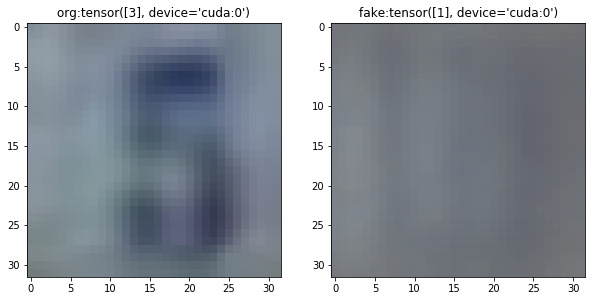

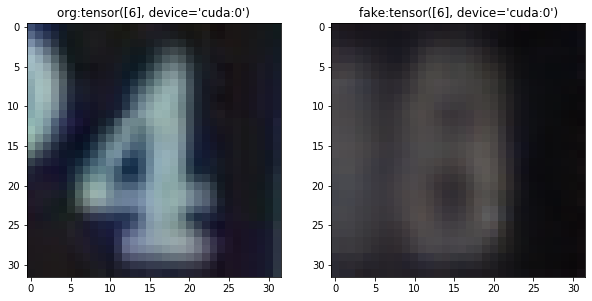

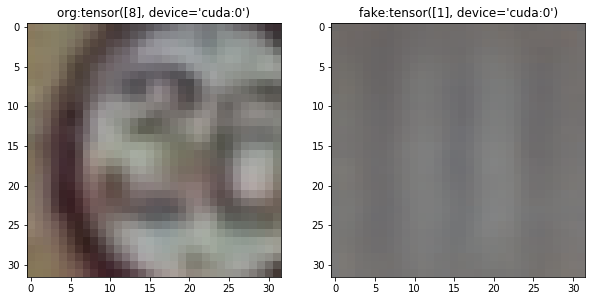

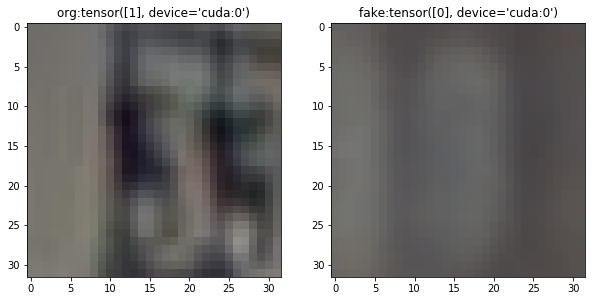

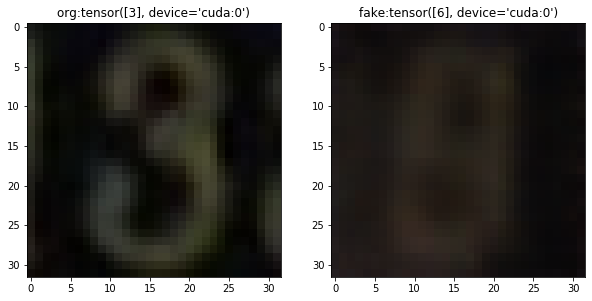

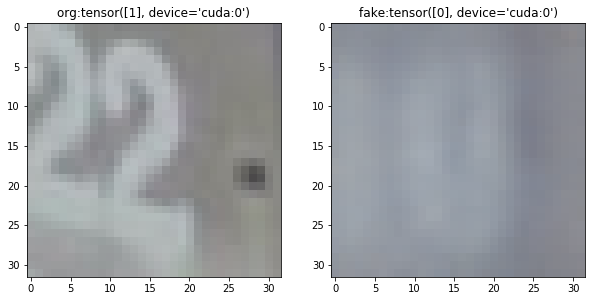

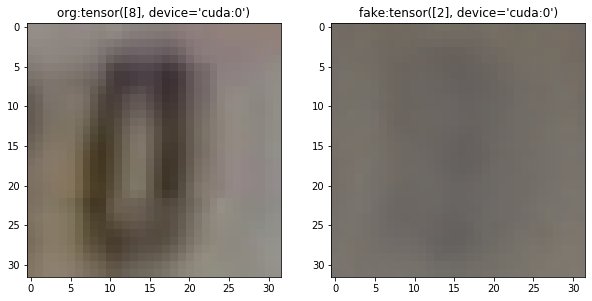

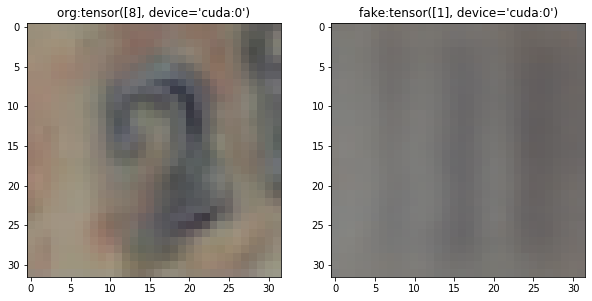

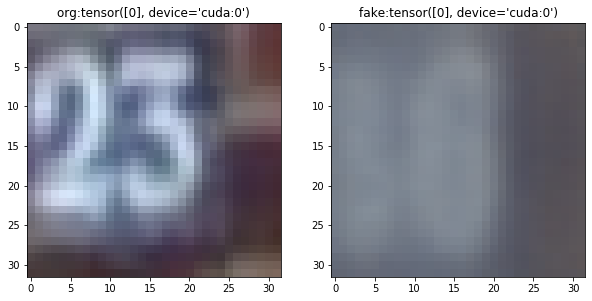

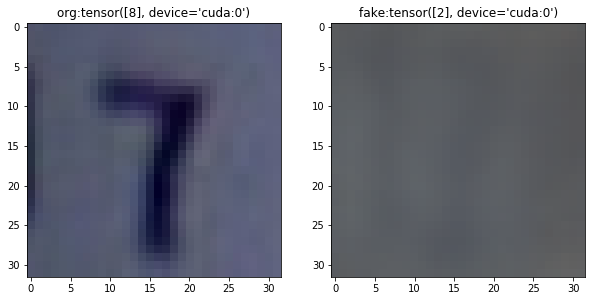

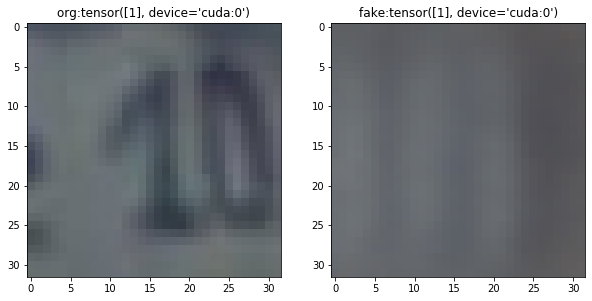

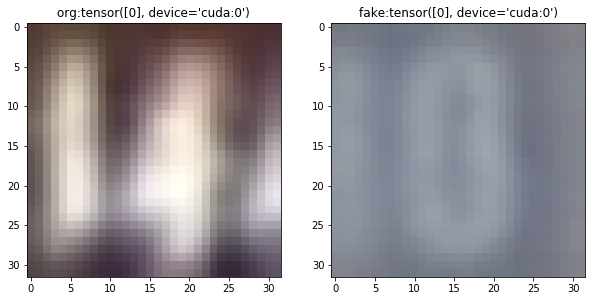

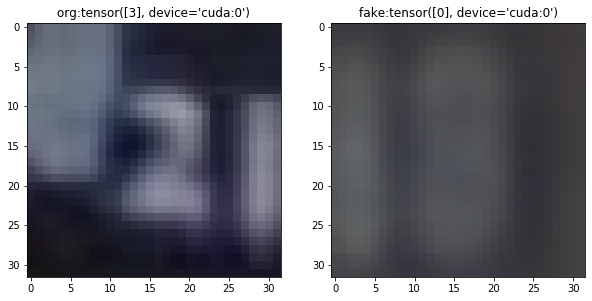

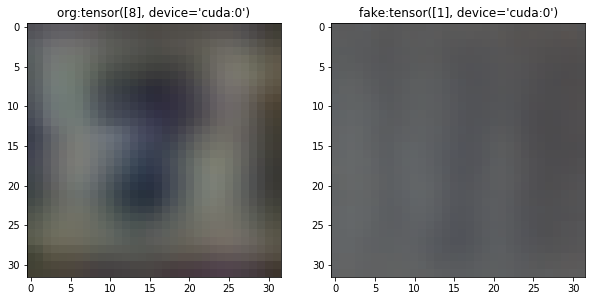

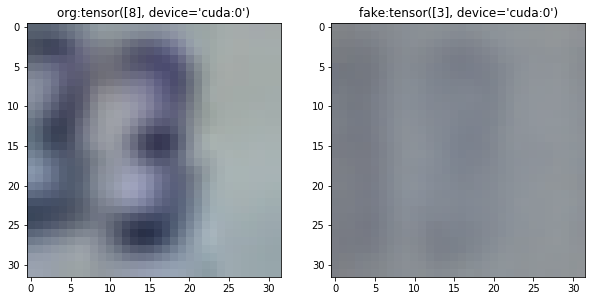

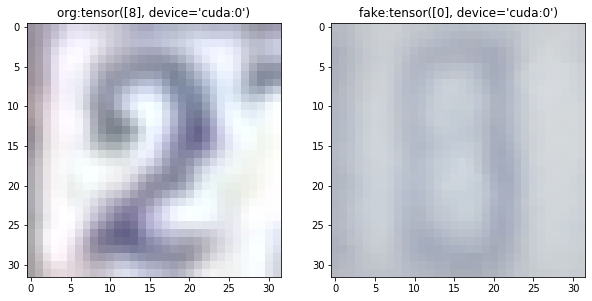

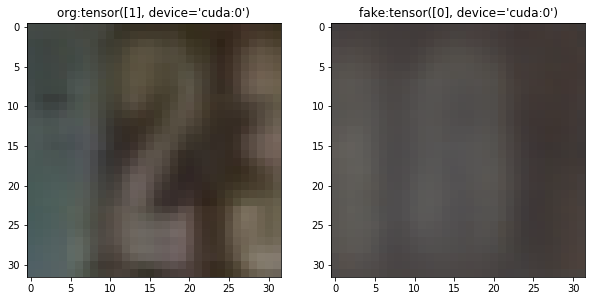

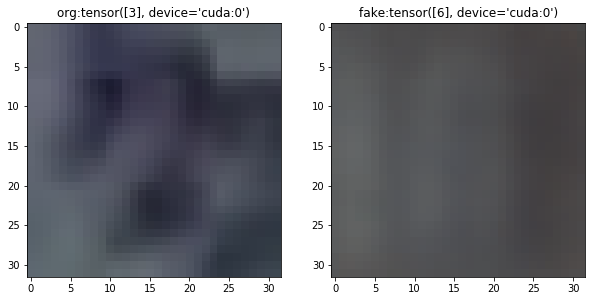

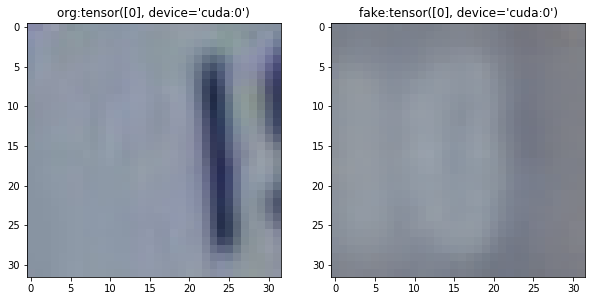

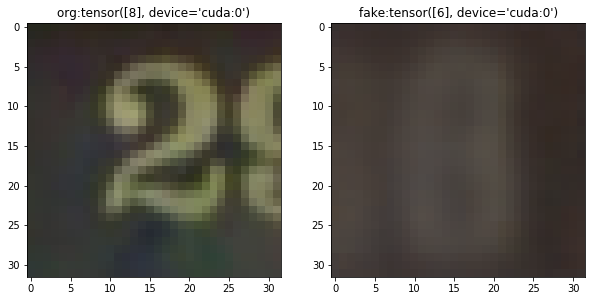

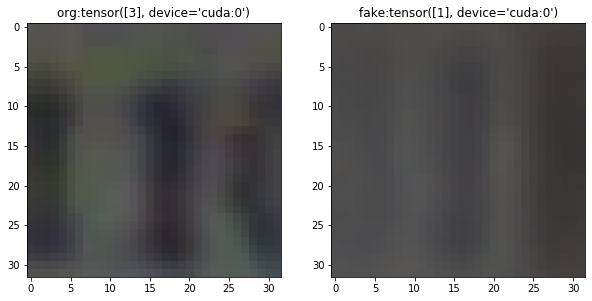

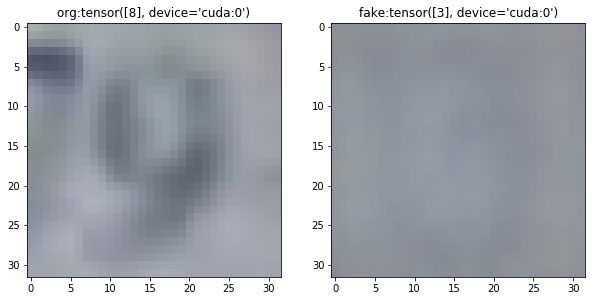

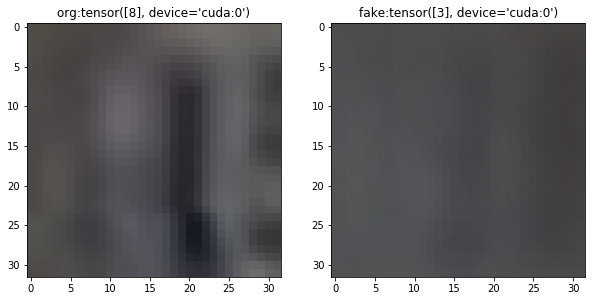

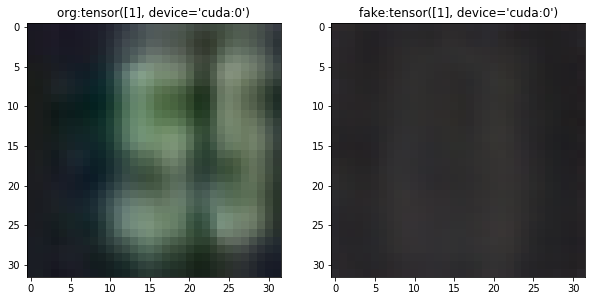

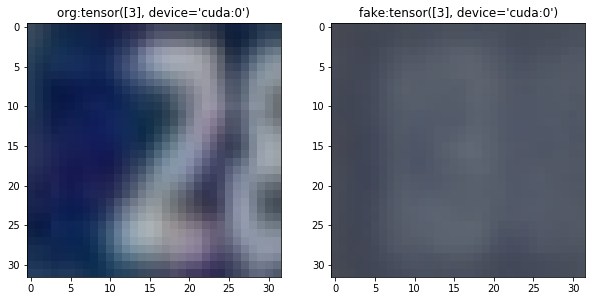

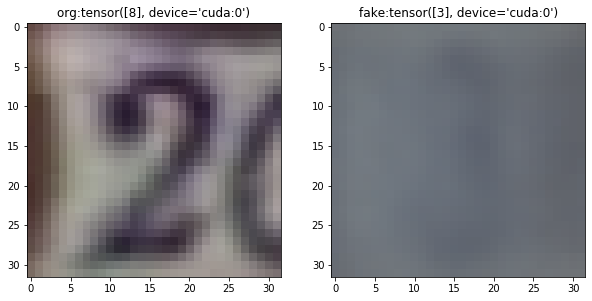

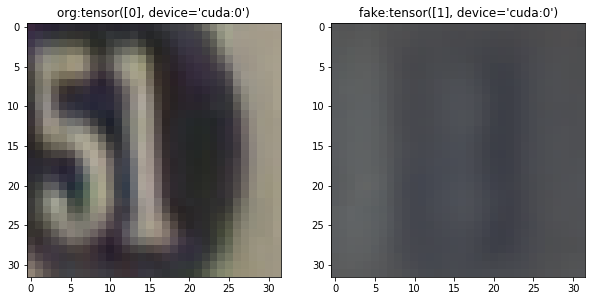

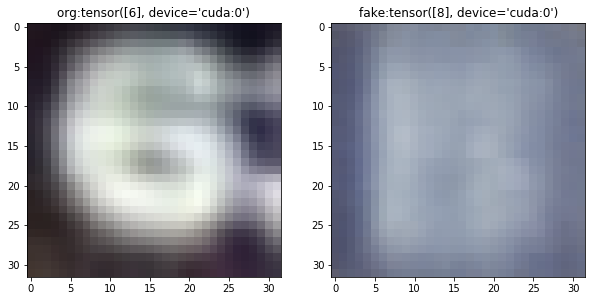

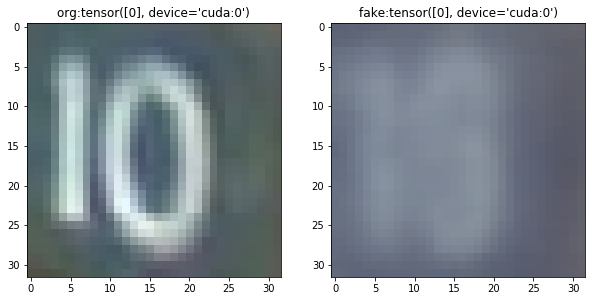

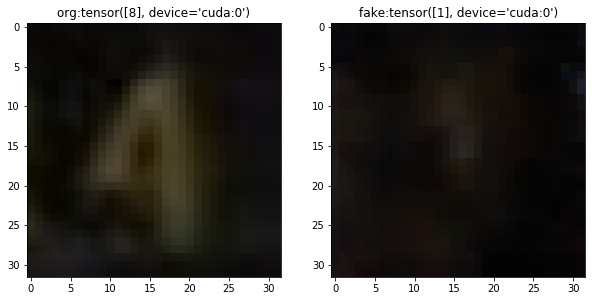

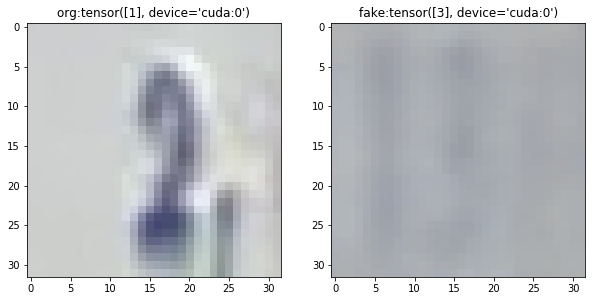

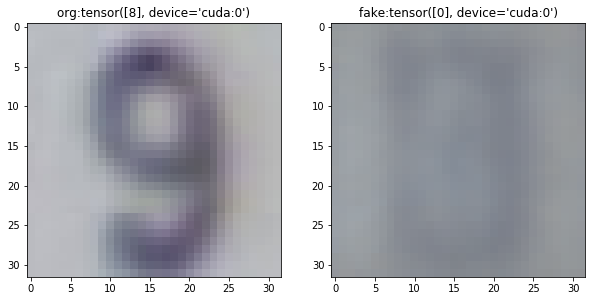

In [59]:
for i in range(32):
    check(i,0.5,0.5)

In [ ]:
def test(i, means=l_mean_tensor, stds=l_std_tensor, latent_dim=latent_dim, classes=len(train_data.classes)):
    _, l_dist = model(example_data[i].unsqueeze_(0).to(device))
    l_sample = model.reparameterize(l_dist)
    noises = noise(l_sample)
    coffs = cofficient(l_sample)
#     print(coffs.shape)
#     print(noises.shape)
    noised_latent = means + noises.reshape(noises.shape[0], classes, latent_dim)*stds
    noised_latent = coffs[:,:,None]*noised_latent
#     print(noised_latent.shape)
#     print(l_sample.shape)
#     print(torch.transpose(coff[:,None].cuda()*avg_latent.T, 1, 2).sum(1).shape)
#     noised_latent = l_sample + 2e-1*torch.transpose(coff[:,None].cuda()*avg_latent.T, 1, 2).sum(1)
#     print(noised_latent.shape)
#     print(noised_sample)
#     print(l_sample)
#     noised_sample = 1 * ((l_sample - l_sample.min())/(l_sample.max() - l_sample.min())) + 1e-2 * ((noised_sample - noised_sample.min())/(noised_sample.max() - noised_sample.min()))
#     noised_sample = 1 * l_sample + 2e-2 * noised_sample
#     noised_sample = l_sample + 1e-7 * noised_sample
    final = model.decode(l_sample+1e-12*noised_latent.sum(dim=1))
#     print(final.shape)
    pred_org = torch.argmax(classifier(F.upsample(example_data[i,:,:,:].unsqueeze(0).cuda(), (28,28), mode='bilinear', align_corners=True)))
    pred = torch.argmax(classifier(F.upsample(final, (28,28), mode='bilinear', align_corners=True)), dim=1)
#     print(pred)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(example_data[i][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.subplot(1,2,2)
    plt.imshow(final[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title("Prediction: {}, {}".format(pred_org.item(), pred.item()))

In [ ]:
for i in range(64):
    test(i)

In [ ]:
torch.transpose(torch.clamp(coff[:,None].cuda(), min=-0.8, max=0.3)*self.avg_latent.T, 1, 2).sum(1)